# Machine Learning.
В этом проекте я работаю с выложенными в общий доступ данными об энергоэффективности зданий в Нью-Йорке.

Цель: использовать имеющиеся данные для построения модели, которая прогнозирует количество баллов Energy Star Score для конкретного здания, и интерпретировать результаты для поиска факторов, влияющих на итоговый балл.

Оценка Energy Star - это метод ранжирования зданий с точки зрения энергоэффективности: 1 худший и 100 лучших. Это относительный рейтинг в процентах, который означает, что здания оцениваются относительно друг друга и должны отображать равномерное распределение по диапазону значений.

Машинное обучение с управляемой регрессией:


# 1. Очистка данных

##### Выгрузка dataframe Pandas.

In [2]:
import pandas as pd
import numpy as np


data = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/machine-learning-project-walkthrough/master/data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,...,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,...,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840746,-73.942854,12.0,10.0,255.0,Washington Heights South ...
4,5,4778288,Neuro Institute,28400,NYP Columbia (West Campus),1021390085,1-02139-0085,1063403,710 West 168th Street,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.841559,-73.942528,12.0,10.0,255.0,Washington Heights South ...


##### Типы данных и отсутствующие значения
В dataframe.info метод - это быстрый способ оценки данных путем отображения типов данных каждого столбца и количества не пропущенных значений. Уже при просмотре фрейма данных может возникнуть проблема, поскольку отсутствующие значения кодируются как "Недоступные", а не как np.nan (не число). Это означает, что столбцы с числами не будут представлены как числовые, поскольку pandas преобразует столбцы с любыми строковыми значениями в столбцы всех строк.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11746 non-null  object 
 7   NYC Building Identification Number (BIN)                    11746 non-null  object 
 

##### Преобразование данных в правильные типы
Преобразуем столбцы с числами в числовые типы данных, заменив записи "Недоступно" на np.nan, которые можно интерпретировать как числа с плавающей точкой. 

Преобразуем столбцы, содержащие числовые значения (например, квадратные футы или потребление энергии), в числовые типы данных.

In [4]:

data = data.replace({'Not Available': np.nan})

for col in list(data.columns):

    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):

        data[col] = data[col].astype(float)
    

Статистика для каждого столбца

In [5]:
data.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,...,Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,...,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,...,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,...,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,...,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,...,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,...,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,...,4.249000e+02,1.584140e+05,8.031875e+03,70.805000,162.750000,40.817623,-73.932443,9.000000,33.000000,531.500000
max,14993.000000,5.991312e+06,1.354011e+07,1.421712e+07,962428.000000,591640.000000,2019.000000,161.000000,100.000000,100.000000,...,4.764375e+06,1.421712e+07,6.594604e+06,96305.690000,912801.100000,40.912869,-73.715543,56.000000,51.000000,155101.000000


##### Недостающие значения 

Функция, которая вычисляет количество отсутствующих значений и процент от общего числа отсутствующих значений для каждого столбца.

In [6]:
def missing_value_table(df):
    #все недостающие значения 
    mis_val = df.isnull().sum()
    #процент
    mis_val_percent = 100*mis_val/len(df)
    #таблица с результатами 
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1)
    #переименование строк 
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    #сортировка % по убыванию
    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    # информация о сумме
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [7]:
missing_value_table(data)


Your selected dataframe has 60 columns.
There are 46 columns that have missing values.


,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


In [8]:
missing_df = missing_value_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))
#data=data.drop(columns=list(missing_columns))
#print ('columns drop')

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
We will remove 11 columns.


In [9]:
data=data.drop(columns=list(missing_columns))
print ('columns drop')
missing_df = missing_value_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

columns drop
Your selected dataframe has 49 columns.
There are 35 columns that have missing values.
We will remove 0 columns.


In [10]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 49 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11735 non-null  object 
 7   NYC Building Identification Number (BIN)                    11584 non-null  object 
 

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,10017,...,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,10032,...,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,10032,...,NaN,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,10032,...,NaN,04/27/2017 11:23:27 AM,No,In Compliance,40.840746,-73.942854,12.0,10.0,255.0,Washington Heights South ...
4,5,4778288,Neuro Institute,28400,NYP Columbia (West Campus),1021390085,1-02139-0085,1063403,710 West 168th Street,10032,...,NaN,04/27/2017 11:23:27 AM,No,In Compliance,40.841559,-73.942528,12.0,10.0,255.0,Washington Heights South ...


# 2. Исследовательский Анализ Данных

(EDA) - это открытый процесс, в ходе которого мы строим графики и рассчитываем статистику для изучения наших данных. Цель состоит в том, чтобы найти аномалии, закономерности, тенденции или взаимосвязи. Они могут быть интересны сами по себе (например, поиск корреляции между двумя переменными)

In [11]:
#data['score']

Графики с одной переменной


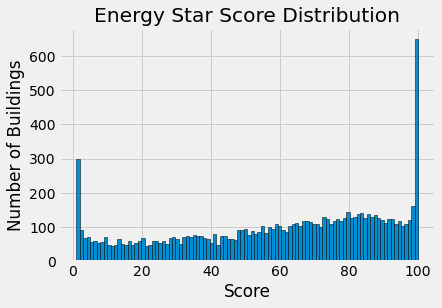

In [12]:
import matplotlib.pyplot as plt

# Rename the score 
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); 
plt.ylabel('Number of Buildings'); 
plt.title('Energy Star Score Distribution');

Оценка Energy Star является процентной, мы ожидаем увидеть равномерное распределение, при этом каждый балл составляет 1% от распределения (около 90 зданий). Однако это определенно не так, поскольку мы видим, что два наиболее распространенных балла, 1 и 100, составляют непропорционально большое количество общих баллов.

Если мы вернемся к определению показателя, то увидим, что он основан на оценке потребления энергии. Это создает проблему, потому что у владельца здания может возникнуть соблазн сообщить о снижении потребления электроэнергии, чтобы искусственно повысить оценку своего здания. Такое поведение могло бы объяснить высокий процент зданий с идеальным результатом 100, но не объясняет, почему так много зданий набирают баллы в самом низу!

Чтобы сравнить оценку Energy Star, мы можем посмотреть на интенсивность энергопотребления (EUI), которая представляет собой общее потребление энергии

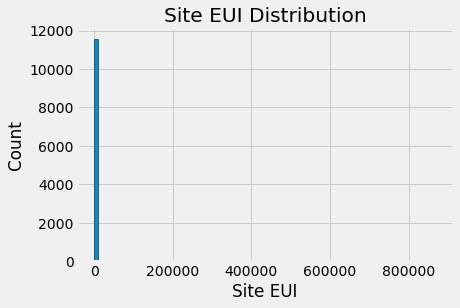

In [13]:
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Site EUI'); 
plt.ylabel('Count');
plt.title('Site EUI Distribution');

График показывает на, что есть еще одна проблема: выбросы. График искажен из-за наличия нескольких зданий с очень высокими баллами.  

In [14]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [15]:
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10)

3173     51328.8
3170     51831.2
3383     78360.1
8269     84969.6
3263     95560.2
8268    103562.7
8174    112173.6
3898    126307.4
7       143974.4
8068    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64

Одно здание явно намного выше остальных.

In [16]:
data.loc[data['Site EUI (kBtu/ft²)'] == 869265, :]

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
8068,9984,4414323,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,...,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


Отклонения могут возникать по многим причинам: опечатки, неисправности в измерительных приборах, неправильные единицы измерения, или они могут быть допустимыми, но экстремальными значениями. Выбросы могут нарушить модель, поскольку они не отражают фактическое распределение данных.

###### Удаление Выбросов

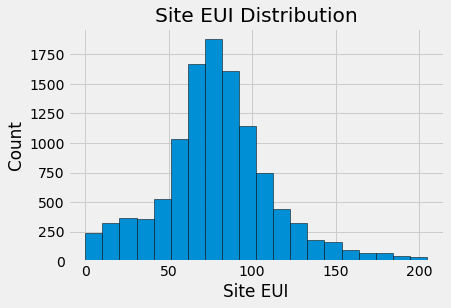

In [17]:
# Calculate first and third quartile
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]
# Histogram Plot of Site EUI

plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Site EUI Distribution');

##### Поиск взаимоотношений

Multifamily Housing                      7464
Office                                   1157
Hotel                                     202
Non-Refrigerated Warehouse                156
K-12 School                                97
Residence Hall/Dormitory                   96
Senior Care Community                      85
Distribution Center                        61
Retail Store                               57
Medical Office                             23
Hospital (General Medical & Surgical)      15
Financial Office                           12
Supermarket/Grocery Store                  10
Worship Facility                            9
Refrigerated Warehouse                      8
Parking                                     3
Wholesale Club/Supercenter                  3
Courthouse                                  2
Bank Branch                                 1
Name: Largest Property Use Type, dtype: int64


['Multifamily Housing', 'Office', 'Hotel', 'Non-Refrigerated Warehouse']


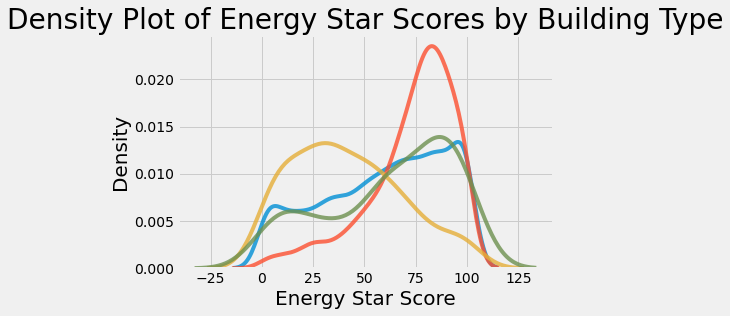

In [18]:
import seaborn as sns
types = data.dropna(subset = ['score'])
#print(types)
types = types['Largest Property Use Type'].value_counts()
print(types)
types = list(types[types.values>100].index)
print('\n')
print(types)

for b_type in types:
    subset = data[data['Largest Property Use Type'] == b_type]
    sns.kdeplot(subset['score'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28);

Чтобы посмотреть на влияние категориальных переменных на оценку, мы можем построить график плотности, окрашенный значением категориальной переменной. Графики плотности также показывают распределение одной переменной и могут рассматриваться как сглаженная гистограмма. Если мы раскрасим кривые плотности категориальной переменной, это покажет нам, как меняется распределение в зависимости от класса.

Первый график, который мы сделаем, показывает распределение баллов по типу недвижимости. Чтобы не загромождать график, мы ограничим график типами зданий, в наборе данных которых содержится более 100 наблюдений.

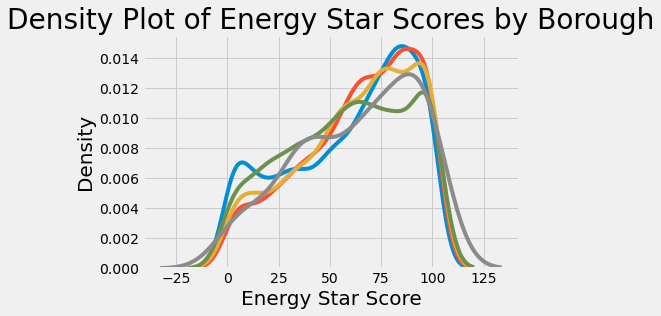

In [19]:
boroughs = data.dropna(subset=['score'])
#print(boroughs)
boroughs = boroughs['Borough'].value_counts()
#print(boroughs)
boroughs = list(boroughs[boroughs.values > 100].index)
#print(boroughs)

for borough in boroughs:
    # Select the building type
    subset = data[data['Borough'] == borough]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = borough);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Borough', size = 28);

Из этого графика мы видим, что тип здания действительно влияет на оценку. Мы должны включить тип свойства, потому что эта информация может быть полезна для определения оценки. Поскольку тип здания является категориальной переменной, он должен быть закодирован одним нажатием кнопки, прежде чем мы сможем ввести его в модель машинного обучения.

Чтобы изучить другую категориальную переменную, район, мы можем построить тот же график, но на этот раз окрашенный районом.

##### Коэффициент корреляции Пирсона. 
##### Корреляции между функциями и целью
Значение +1 означает идеально линейную положительную зависимость, а -1 означает идеально линейную отрицательную зависимость.

Приведенный ниже код вычисляет коэффициенты корреляции между всеми переменными и оценкой

In [20]:
correlations_data = data.corr()['score'].sort_values()
# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

Существует несколько сильных отрицательных корреляций между функциями и целью. Наиболее отрицательными корреляциями с оценкой являются различные категории Интенсивности энергопотребления (EUI), EUI участка (кБту/фут2) и EUI участка с учетом погодных условий (кБту/фут2) (они незначительно различаются по способу расчета). EUI - это количество энергии, потребляемой зданием, деленное на площадь зданий, и предназначено для измерения эффективности здания, при этом более низкий балл является лучшим. Интуитивно эти корреляции тогда имеют смысл: по мере увеличения EUI оценка Energy Star имеет тенденцию к снижению.

Чтобы учесть возможные нелинейные взаимосвязи, мы можем взять квадратный корень и натуральные логарифмические преобразования признаков, а затем рассчитать коэффициенты корреляции с оценкой. 

В следующем коде мы берем логарифмические преобразования числовых переменных и преобразования квадратного корня, однократно кодируем две выбранные категориальные переменные (тип здания и район), вычисляем корреляции между всеми функциями и оценкой и отображаем 15 наиболее положительных и 15 наиболее отрицательных корреляций. 

In [21]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['score'])

# Find correlations with the score 
correlations = features.corr()['score'].dropna().sort_values()

C:\Users\Eliz\AppData\Local\Temp/ipykernel_15804/522778228.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
C:\Users\Eliz\AppData\Local\Temp/ipykernel_15804/522778228.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset['log_' + col] = np.log(numeric_subset[col])
C:\Users\Eliz\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **k

In [22]:
# Display most negative correlations
correlations.head(15)

Site EUI (kBtu/ft²)                                            -0.723864
Weather Normalized Site EUI (kBtu/ft²)                         -0.713993
sqrt_Site EUI (kBtu/ft²)                                       -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.671044
sqrt_Source EUI (kBtu/ft²)                                     -0.669396
Weather Normalized Source EUI (kBtu/ft²)                       -0.645542
Source EUI (kBtu/ft²)                                          -0.641037
log_Source EUI (kBtu/ft²)                                      -0.622892
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.620329
log_Site EUI (kBtu/ft²)                                        -0.612039
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.601332
log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.424246
sqrt_Weather Normalized Site Electricity Intensity 

In [23]:
# Display most positive correlations
correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
log_Community Board                                                0.055495
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
log_Council District                                               0.061101
Council District                                                   0.061639
Largest Prop

После преобразования функций наиболее прочными остаются взаимосвязи, связанные с интенсивностью энергопотребления (EUI). Преобразования логарифма и квадратного корня, похоже, не привели к каким-либо более прочным отношениям. Сильных положительных линейных зависимостей нет, хотя мы видим, что тип здания офиса (Тип наибольшего использования недвижимости) слегка положительно коррелирует с оценкой. Эта переменная представляет собой однократное кодированное представление категориальных переменных для типа здания.

Построим график наиболее значимой корреляции (с точки зрения абсолютного значения) в наборе данных, который является EUI (кБту /фут ^ 2). 

## Графики от двух переменных 

Чтобы визуализировать взаимосвязь между двумя переменными, мы используем диаграмму рассеяния. Мы также можем включить дополнительные переменные, используя такие аспекты, как цвет маркеров или размер маркеров. Здесь мы построим две числовые переменные друг против друга и будем использовать цвет для представления третьей категориальной переменной.

C:\Users\Eliz\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Eliz\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Energy Star Score vs Site EUI')

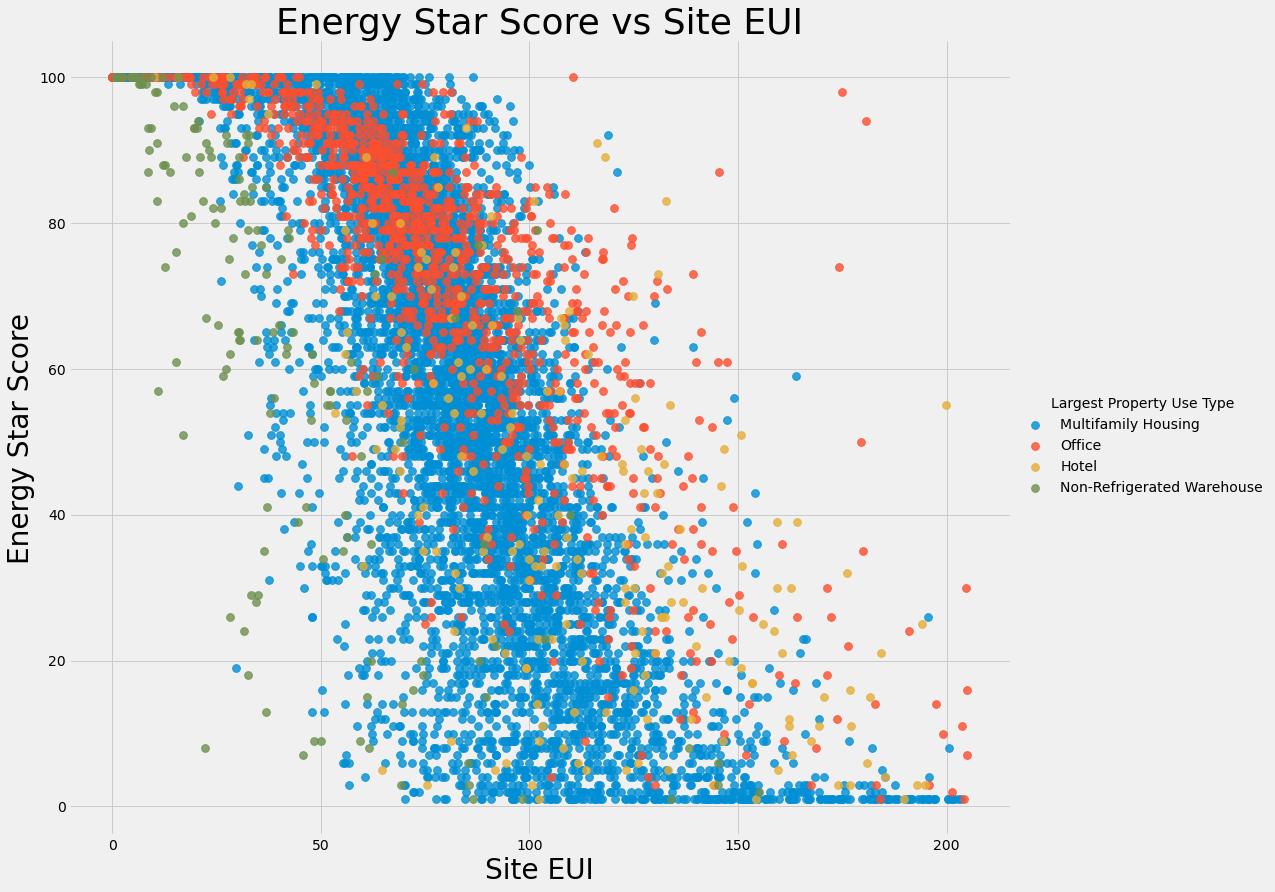

In [24]:
#извлечение типов данных 
features['Largest Property Use Type'] = data.dropna(subset=['score'])['Largest Property Use Type']
# Ограничение на типы зданий с более чем 100 наблюдениями (из предыдущего кода)
features = features[features['Largest Property Use Type'].isin(types)]
#Использование searnborn для построения диаграммы рассеяния баллов по сравнению с источником журнала EUI
sns.lmplot('Site EUI (kBtu/ft²)', 'score',
          hue = 'Largest Property Use Type', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60},fit_reg = False,
          size=12,aspect = 1.2);
#Лейблы
plt.xlabel("Site EUI",size = 28)
plt.ylabel('Energy Star Score', size=28)
plt.title ('Energy Star Score vs Site EUI',size=36)

## Парный график 

Построим график пар между несколькими различными переменными. График пар - отличный способ изучить множество переменных одновременно, поскольку он показывает диаграммы рассеяния между парами переменных и гистограммы отдельных переменных по диагонали.

Используя функцию seaborn PairGrid, мы можем сопоставлять различные графики с тремя аспектами сетки. В верхнем треугольнике будут диаграммы рассеяния, на диагонали будут показаны гистограммы, а в нижнем треугольнике будут показаны как коэффициент корреляции между двумя переменными, так и оценка плотности двух переменных в 2-D ядре.

C:\Users\Eliz\anaconda3\lib\site-packages\seaborn\axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


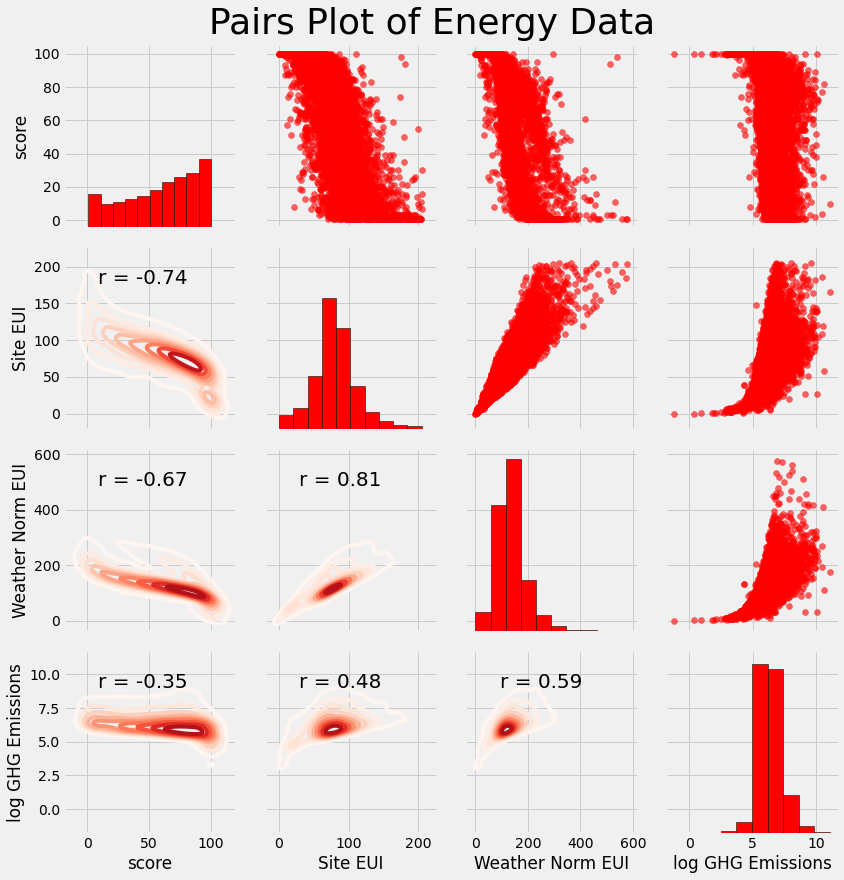

In [25]:
import seaborn
# Extract the columns to  plot
plot_data = features[['score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Rename columns 
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);

Чтобы увидеть взаимосвязи переменных, поищем пересечения рядов и колонок. Допустим, нужно посмотреть корреляцию Weather Norm EUI и score, тогда мы ищем ряд Weather Norm EUI и колонку score, на пересечении которых стоит коэффициент корреляции -0,67. Эти графики не только классно выглядят, но и помогают выбрать переменные для модели.

## Выбор и создание новых признаков 

Конструирование признаков: процесс извлечения или создания новых признаков из сырых данных. Чтобы использовать переменные в модели, возможно, их придётся преобразовывать, скажем, брать натуральный логарифм, или извлекать квадратный корень, или применять one-hot кодирование категориальных переменных. Конструирование признаков можно рассматривать как создание дополнительных признаков из сырых данных.

Выбор признаков: процесс выбора из данных самых релевантных признаков, в ходе которого мы удаляем часть признаков, чтобы помочь модели лучше обобщать новые данные ради получения более интерпретируемой модели. Выбор признаков можно рассматривать как удаление «лишнего», чтобы осталось только самое важное.

One-hot кодирование необходимо для того, чтобы включить в модель категориальные переменные. Алгоритм машинного обучения не сможет понять тип «офис», так что если здание офисное, мы присвоим ему признак 1, а если не офисное, то 0.

Добавление преобразованных признаков поможет модели узнать о нелинейных взаимосвязях внутри данных. В анализе данных является нормальной практикой извлекать квадратные корни, брать натуральные логарифмы или ещё как-то преобразовывать признаки, это зависит от конкретной задачи или вашего знания лучших методик. В данном случае мы добавим натуральный логарифм всех числовых признаков.


Этот код выбирает числовые признаки, вычисляет их логарифмы, выбирает два категориальных признака, применяет к ним one-hot кодирование и объединяет оба множества в одно.

In [26]:
features = data.copy()

numeric_subset = data.select_dtypes('number')

for col in numeric_subset.columns:
    if col=='score':
        next
    else:
        numeric_subset['log_'+ col]=np.log(numeric_subset[col])
        
    categorial_subset = data[['Borough', 'Largest Property Use Type']]
    categorial_subset = pd.get_dummies(categorial_subset)
    
    features = pd.concat([numeric_subset,categorial_subset], axis=1)
    #features.shape
    

C:\Users\Eliz\AppData\Local\Temp/ipykernel_15804/283504626.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset['log_'+ col]=np.log(numeric_subset[col])
C:\Users\Eliz\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Eliz\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
features.shape

(11319, 110)


Теперь у нас есть больше 11 000 наблюдений (зданий) со 110 колонками (признаками). Не все признаки будут полезны для прогнозирования Energy Star Score, поэтому займёмся выбором признаков и удалим часть переменных.

## Выбор признаков

Многие из имеющихся 110 признаков избыточны, потому что сильно коррелируют друг с другом. К примеру, вот график EUI и Weather Normalized Site EUI, у которых коэффициент корреляции равен 0,997.

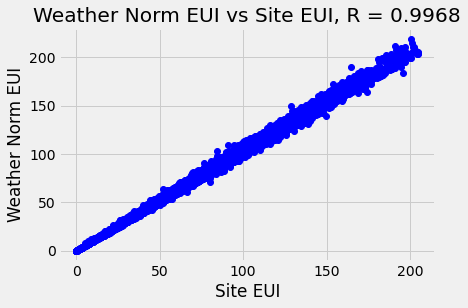

In [28]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI'); plt.ylabel('Weather Norm EUI')

plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1]);


Признаки, которые сильно коррелируют друг с другом, называются коллинеарными. Удаление одной переменной в таких парах признаков часто помогает модели обобщать и быть более интерпретируемой. 

Существует ряд методов вычисления коллинеарности признаков, и один из самых популярных — фактор увеличения дисперсии (variance inflation factor). Мы для поиска и удаления коллинеарных признаков воспользуемся коэффициентом В-корреляции (thebcorrelation coefficient).

In [29]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['score']
    x = x.drop(columns = ['score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    # Add the score back in to the data
    x['score'] = y
               
    return x

In [30]:
# Remove the collinear features above a specified correlation coefficient
features = remove_collinear_features(features, 0.6);

In [31]:
# Remove any columns with all na values
features  = features.dropna(axis=1, how = 'all')
features.shape

(11319, 65)

### Выбираем базовый уровень

исходный базовый уровень (naive baseline) — некое предположение, с которым мы будем сравнивать результаты работы моделей. Если они окажутся ниже базового уровня, мы будем считать, что машинное обучение неприменимо для решения этой задачи, или что нужно попробовать иной подход.

Для регрессионных задач в качестве базового уровня разумно угадывать медианное значение цели на обучающем наборе для всех примеров в тестовом наборе. Эти наборы задают барьер, относительно низкий для любой модели.

В качестве метрики возьмём среднюю абсолютную ошибку (mae) в прогнозах.

Прежде чем вычислять базовый уровень, нужно разбить данные на обучающий и тестовый наборы:

In [32]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['score'].isna()]
score = features[features['score'].notnull()]

print(no_score.shape)
print(score.shape)

(1858, 65)
(9461, 65)


In [65]:
from sklearn.model_selection import train_test_split
# Separate out the features and targets
features = score.drop(columns='score')
targets = pd.DataFrame(score['score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(6622, 64)
(2839, 64)
(6622, 1)
(2839, 1)


In [66]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [67]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 66.00
Baseline Performance on the test set: MAE = 24.5164


Средняя абсолютная ошибка на тестовом наборе составила около 25 пунктов. Поскольку мы оцениваем в диапазоне от 1 до 100, то ошибка составляет 25 % — довольно низкий барьер для модели!